Wait for 8 seconds...
TensorBoard link:
http://663819e0.ngrok.io
Training with lambda = 0
Epoch 20/100| Avg loss: 0.13996
Epoch 40/100| Avg loss: 0.11982
Epoch 60/100| Avg loss: 0.11248
Epoch 80/100| Avg loss: 0.1104
Epoch 100/100| Avg loss: 0.10985
---------------------------------
Training with lambda = 0.001
Epoch 20/100| Avg loss: 0.14005
Epoch 40/100| Avg loss: 0.11994
Epoch 60/100| Avg loss: 0.11264
Epoch 80/100| Avg loss: 0.11059
Epoch 100/100| Avg loss: 0.11005
---------------------------------
Training with lambda = 0.01
Epoch 20/100| Avg loss: 0.14079
Epoch 40/100| Avg loss: 0.121
Epoch 60/100| Avg loss: 0.11411
Epoch 80/100| Avg loss: 0.11225
Epoch 100/100| Avg loss: 0.11178
---------------------------------
Training with lambda = 0.1
Epoch 20/100| Avg loss: 0.14823
Epoch 40/100| Avg loss: 0.13139
Epoch 60/100| Avg loss: 0.12746
Epoch 80/100| Avg loss: 0.12678
Epoch 100/100| Avg loss: 0.12667
---------------------------------
Training with lambda = 1
Epoch 20/100| Avg loss: 

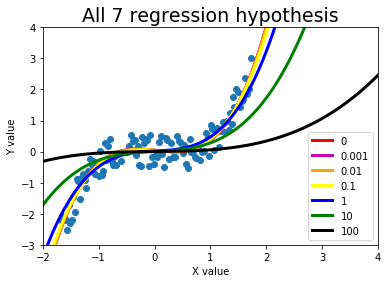

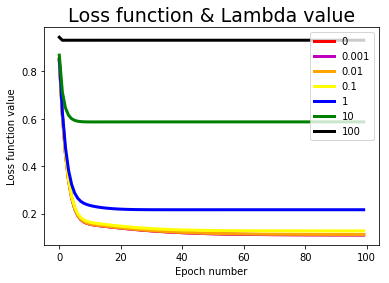

'\nRegularizacoiju koristimo da izbegnemo overfitting. Polinom stepena 3 nam je izgleda\nidealan za ove podatke. \nZa lambdu 10 i 100 dobijamo znatno veći loss, vrednosti 0, 0.001 daju identična rešenja kao\nobična regresija dok lambda od 0.01 i 0.1 nam zapravo može pomoći.\n'

In [32]:
%matplotlib inline
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
from tensorboardcolab import * 

tf.reset_default_graph()

# Pravimo feature matricu od trening podataka
def create_feature_matrix(x, nb_features):
  tmp_features = []
  for deg in range(1, nb_features+1):
    tmp_features.append(np.power(x, deg))
  return np.column_stack(tmp_features)
  

# Preciznost
np.set_printoptions(suppress=True, precision=15)  

# Učitavanje podataka
filename = 'funky.csv'
all_data = np.loadtxt(filename, delimiter=',', skiprows=0, usecols=(0, 1))
data = dict()
featured_data = dict()
data['x'] = all_data[:, 0]
data['y'] = all_data[:, 1]
nb_samples = data['x'].shape[0]

# Normalizacija
data['x'] = (data['x'] - np.mean(data['x'])) / np.std(data['x'])
data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

# Iscrtavanje podataka
plt.scatter(data['x'], data['y'])
plt.xlabel('X value')
plt.ylabel('Y value')

colors = ['r','m','orange','yellow','blue','g', 'k']
c = 0
all_losses = []
nb_features = 3
lambda_value = [0, 0.001, 0.01, 0.1, 1, 10, 100]

i = 0

for lam in lambda_value:   
  
  featured_data = create_feature_matrix(data['x'], nb_features)
  epoch_loss_list = []
  
  # Definisanje modela
  X = tf.placeholder(shape=(None, nb_features), dtype=tf.float32, name='X_value')
  Y = tf.placeholder(shape=(None), dtype=tf.float32, name='Y_value')
  w = tf.Variable(tf.zeros(nb_features), name='initial_weights')
  bias = tf.Variable(0.0, name='inidial_bias')

  w_col = tf.reshape(w, (nb_features, 1), name='reshaped_weights')
  hyp = tf.add(tf.matmul(X, w_col), bias, name='hypotesis')
  
  # Funkcija troska i Adam optimizator
  Y_col = tf.reshape(Y, (-1, 1), name='reshaped_Y')
  
  # L2 regularization
  loss = tf.reduce_mean(tf.square(hyp - Y_col), name='loss_before_regularization')
  regularizer = tf.nn.l2_loss(w_col, name='regularizer')
  loss = tf.reduce_mean(loss + lam * regularizer, name='loss_after_regularization')
  
  opt_op = tf.train.AdamOptimizer().minimize(loss)
  
  if i == 0:
    tbc = TensorBoardColab()
    writer = tbc.get_writer()
    writer.add_graph(tf.get_default_graph())
    writer.flush()
    i = 1

  # Treniranje
  with tf.Session() as sess:
    print("Training with lambda = {}".format(lam))
    sess.run(tf.global_variables_initializer())
    nb_epochs = 100 # Realno i ovo je mnogo

    # Jedna epoha = jedan prolaz kroz ceo trening set
    for epoch in range(nb_epochs):
      epoch_loss = 0

      for sample in range(nb_samples):
        feed = {X: featured_data[sample].reshape((1, nb_features)), 
                Y: data['y'][sample]}
        _, curr_loss = sess.run([opt_op, loss], feed_dict=feed)
        epoch_loss += curr_loss

      epoch_loss /= nb_samples
      epoch_loss_list.append(epoch_loss)
      if(epoch + 1) % 20 == 0:
        print("Epoch {}/{}| Avg loss: {:.5}".format(epoch + 1, nb_epochs, epoch_loss))
        
    # Završili smo treniranje (100 puta prošli kroz ceo trening set)  
    all_losses.append(epoch_loss_list)
    w_val = sess.run(w)
    bias_val = sess.run(bias)
    xs = create_feature_matrix(np.linspace(-2, 4, 100), nb_features)
    hyp_val = sess.run(hyp, feed_dict={X: xs})
    
    plt.plot(xs[:, 0].tolist(), hyp_val.tolist(), color=colors[c], linewidth=3, label=str(lam))
    c += 1
    
    print("---------------------------------")


plt.title('All 7 regression hypothesis', fontsize=19)
plt.legend(loc='lower right')
plt.xlim([-2, 4])
plt.ylim([-3, 4])
plt.show()

c = 0
plt.title('Loss function & Lambda value', fontsize=19)
plt.xlabel('Epoch number')
plt.ylabel('Loss function value')

for loss in all_losses:
  x_axis = list(range(nb_epochs))
  y_axis = loss
  plt.plot(x_axis, y_axis, linewidth=3, color=colors[c], label=str(lambda_value[c]))
  c += 1
  
plt.legend(loc='upper right')
plt.show()


'''
Regularizacoiju koristimo da izbegnemo overfitting. Polinom stepena 3 nam je izgleda
idealan za ove podatke. 
Za lambdu 10 i 100 dobijamo znatno veći loss, vrednosti 0, 0.001 daju identična rešenja kao
obična regresija dok lambda od 0.01 i 0.1 nam zapravo može pomoći.
'''




